In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt

In [2]:
def initial_field(x, y):

    zero_wus = np.zeros((len(y), len(x)))
    zero_clv = np.zeros((len(y), len(x)))

    # 2D Gaussian(sigma:分散共分散行列, mu:平均ベクトル)
    # sigma11,22 = low diffusion < high diffusion
    # sigma12, 21
    sigma11, sigma22, sigma12, sigma21 = 6, 3, 0, 0
    sigma = np.array([[sigma11, sigma12],
                      [sigma21, sigma22]])
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)


    def get_wus(z, mu_wus_x, mu_wus_y):
       mu_wus = np.array([mu_wus_x, mu_wus_y])

       def z_wus(z):
            z_wus = z.T
            for i in range(len(z)):
                for j in range(len(z.T)):
                    Xa = np.array([x[i], y[j]])
                    z_wus[i, j] = (1 / np.sqrt(2 * np.pi * det_sigma)) * np.exp((-1 / 2) * (Xa - mu_wus).T @ inv_sigma @ (Xa - mu_wus)) *10
            return z_wus

       zz_wus = z_wus(z)
       zzz_wus = zz_wus.T

       return zzz_wus


    def get_clv(z, mu_clv_x, mu_clv_y):
       mu_clv = np.array([mu_clv_x, mu_clv_y])

       def z_clv(z):
            z_clv = z.T
            for i in range(len(z)):
                for j in range(len(z.T)):
                    Xb = np.array([x[i], y[j]])
                    z_clv[i, j] = (1 / np.sqrt(2 * np.pi * det_sigma)) * np.exp((-1 / 2) * (Xb - mu_clv).T @ inv_sigma @ (Xb - mu_clv)) *5
            return z_clv

       zz_clv = z_clv(z)
       zzz_clv = zz_clv.T

       return zzz_clv

    zzz_wus = get_wus(zero_wus, mu_wus_x, mu_wus_y)
    zzz_clv = get_clv(zero_clv, mu_clv_x, mu_clv_y)

    #print(type(zz_wus))
    #print(zz_wus.shape)

    return zzz_wus, zzz_clv

def boundary_condition(a):
    a[:, 0], a[:, -1], a[0, :], a[-1, :] = 0, 0, 0, 0  # left, right, up. bottom

    return a


def sol_2d_diffusion(x, y, wus, clv, pull):
    ''' 2次元拡散方程式を計算する '''

    dt, dx, dy, a, step, result_interval =\
       pull[0], pull[1], pull[2], pull[3], pull[4], pull[5]

    wus = wus.T
    clv = clv.T

    for n in range(step):
        wus0 = wus.copy()
        clv0 = clv.copy()

        for i in range(1, len(wus) - 1):
            for j in range(1, len(wus.T) - 1):
                r, s = a * (dt / dx ** 2), a * (dt / dy ** 2)

                wus[i, j] = wus0[i, j] + r * (wus0[i+1, j] - 2 * wus0[i, j] + wus0[i-1, j]) + \
                          s * (wus0[i, j+1] - 2 * wus0[i, j] + wus0[i, j-1])
                clv[i, j] = clv0[i, j] + r * (clv0[i+1, j] - 2 * clv0[i, j] + clv0[i-1, j]) + \
                          s * (clv0[i, j+1] - 2 * clv0[i, j] + clv0[i, j-1])


        # 境界条件を設定
        wus = wus.T
        wus = boundary_condition(wus)
        wus = wus.T

        clv = clv.T
        clv = boundary_condition(clv)
        clv = clv.T

        # 指定した間隔で画像保存
        if n % result_interval == 0:
            print('Iteration=', n)

            wus = wus.T
            plot(x, y, wus, n, 1, wus_str, c_wus)
            wus = wus.T



        if n % result_interval == 0:
            print('Iteration=', n)

            clv = clv.T
            plot(x, y, clv, n, 1, clv_str, c_clv)
            clv = clv.T


    return


def plot(x, y, z, n, save_flag, name, color):

    plt.rcParams['font.size'] = 14
    # scale inside
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    x_size = 8
    y_size = int(0.8 * x_size * (np.max(y) / np.max(x)))
    fig = plt.figure(figsize=(x_size, y_size))
    ax1 = fig.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.set_xlabel('x_label')
    ax1.set_ylabel('y_label')

    # データをプロットする。
    im = ax1.imshow(z,
                    vmin=0, vmax=1,
                    extent=[np.min(x), np.max(x), np.min(y), np.max(y)],
                    aspect='auto', cmap=f'{color}')

    ax1.text(0.1, 0.1, 'Step='+str(n), color="white")

    # カラーバーを設定する。
    cbar = fig.colorbar(im)
    cbar.set_label(f'{name}')

    plt.show()

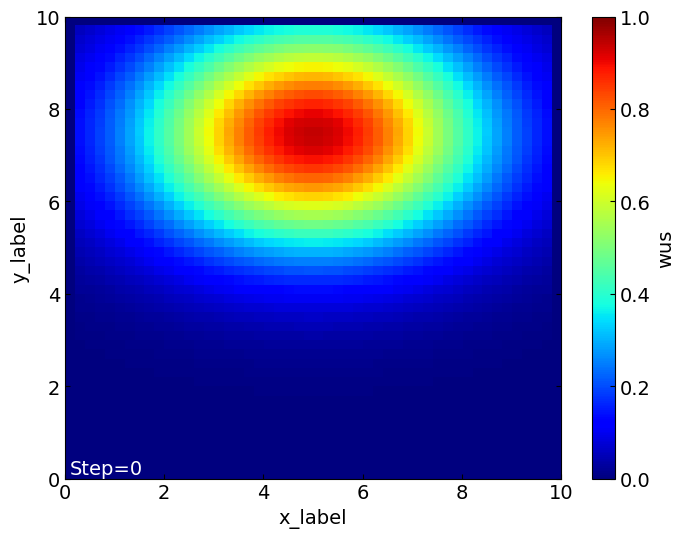

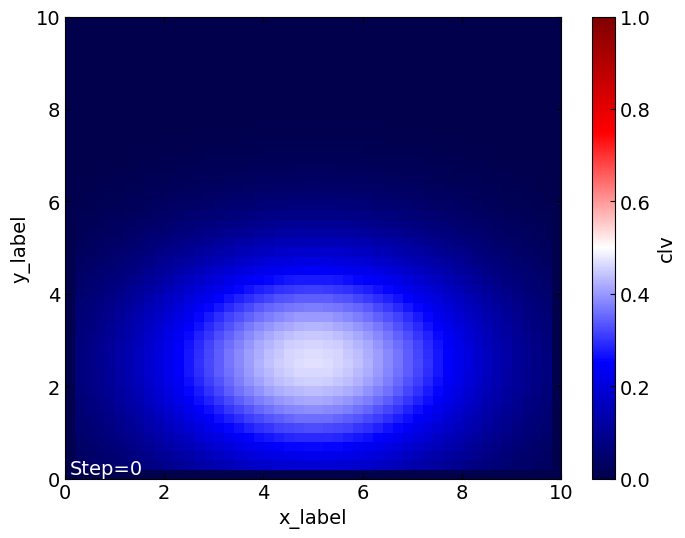

In [5]:
if __name__ == '__main__':

    # Parameter
    dt = 0.005  # Time

    # Space
    x_max, y_max = 10, 10  # range
    dx, dy = 0.2, 0.2  # divide

    mu_wus_x, mu_wus_y = 5, 2.5
    mu_clv_x, mu_clv_y = 5, 7.5

    # diffusion rate
    a = 1
    a_wus = 1
    a_clv = 1

    # Calculation condition
    step = 400
    result_interval = 100

    # component
    wus_str, clv_str = 'wus', 'clv'
    c_wus, c_clv = 'jet', 'seismic'
    # 'plasma', 'cividis', 'twilight_shifted', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg'


    #引数list
    pull_sol = [dt, dx, dy, a, step, result_interval]

    # Initial field
    x, y = np.linspace(0, x_max, int(x_max / dx)), np.linspace(0, y_max, int(y_max / dy))
    wus, clv = initial_field(x, y)
    #plot(x, y, wus, 0, dir, 0)

    # 境界条件を設定する
    wus = boundary_condition(wus)
    clv = boundary_condition(clv)
    plot(x, y, wus, 0, 0, wus_str, c_wus)
    plot(x, y, clv, 0, 0, clv_str, c_clv)

nu_x, nu_y= 12.499999999999998 12.499999999999998
Iteration= 0


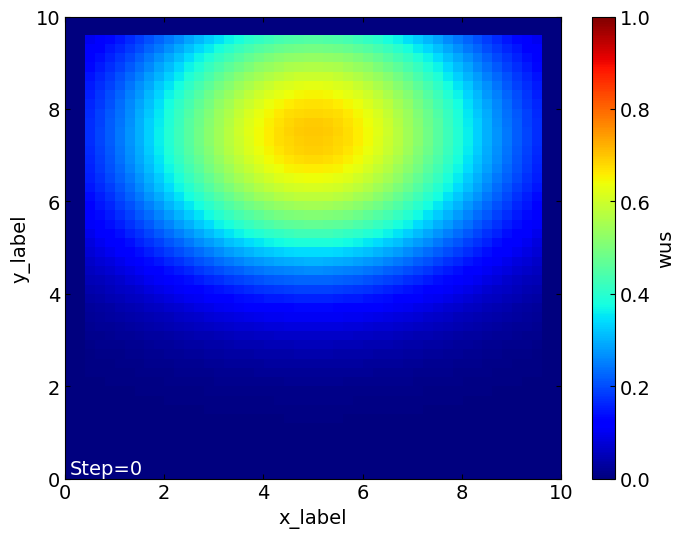

Iteration= 0


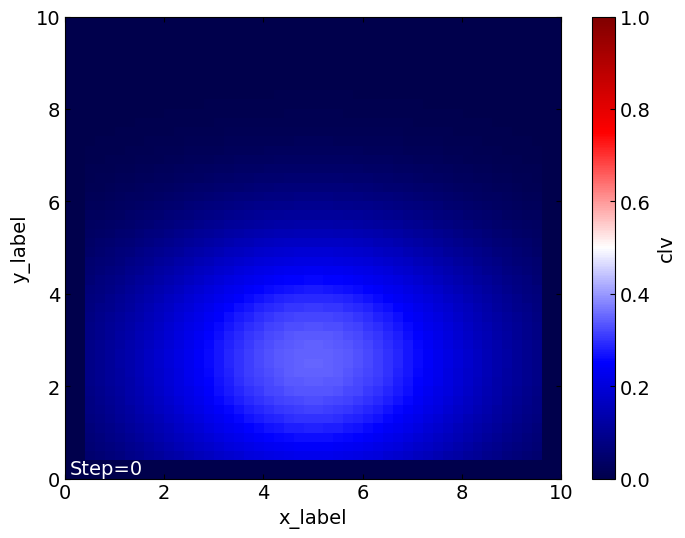

Iteration= 100


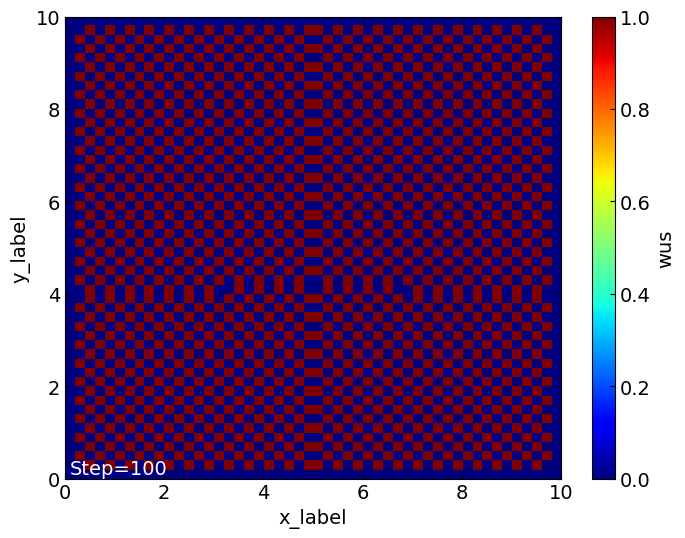

Iteration= 100


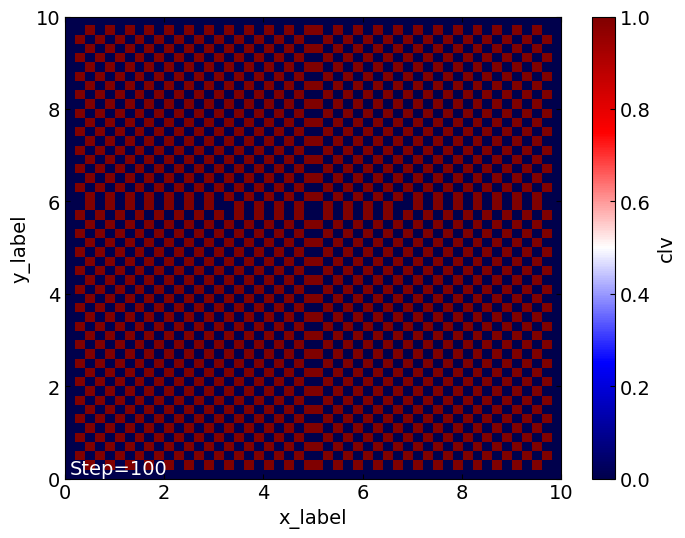

<ipython-input-2-5b58371ad6b0>:80: RuntimeWarning: overflow encountered in scalar add
  wus[i, j] = wus0[i, j] + r * (wus0[i+1, j] - 2 * wus0[i, j] + wus0[i-1, j]) + \
<ipython-input-2-5b58371ad6b0>:80: RuntimeWarning: overflow encountered in scalar multiply
  wus[i, j] = wus0[i, j] + r * (wus0[i+1, j] - 2 * wus0[i, j] + wus0[i-1, j]) + \
<ipython-input-2-5b58371ad6b0>:81: RuntimeWarning: overflow encountered in scalar multiply
  s * (wus0[i, j+1] - 2 * wus0[i, j] + wus0[i, j-1])
<ipython-input-2-5b58371ad6b0>:82: RuntimeWarning: overflow encountered in scalar add
  clv[i, j] = clv0[i, j] + r * (clv0[i+1, j] - 2 * clv0[i, j] + clv0[i-1, j]) + \
<ipython-input-2-5b58371ad6b0>:82: RuntimeWarning: overflow encountered in scalar multiply
  clv[i, j] = clv0[i, j] + r * (clv0[i+1, j] - 2 * clv0[i, j] + clv0[i-1, j]) + \
<ipython-input-2-5b58371ad6b0>:83: RuntimeWarning: overflow encountered in scalar multiply
  s * (clv0[i, j+1] - 2 * clv0[i, j] + clv0[i, j-1])
<ipython-input-2-5b58371ad6b0>

Iteration= 200


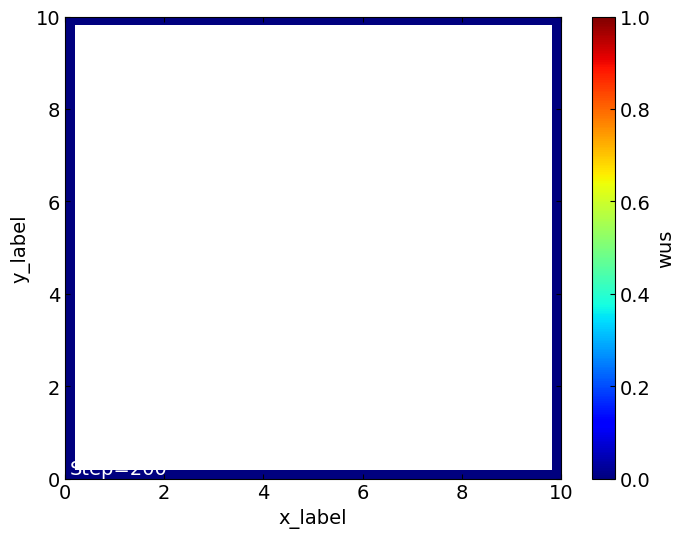

Iteration= 200


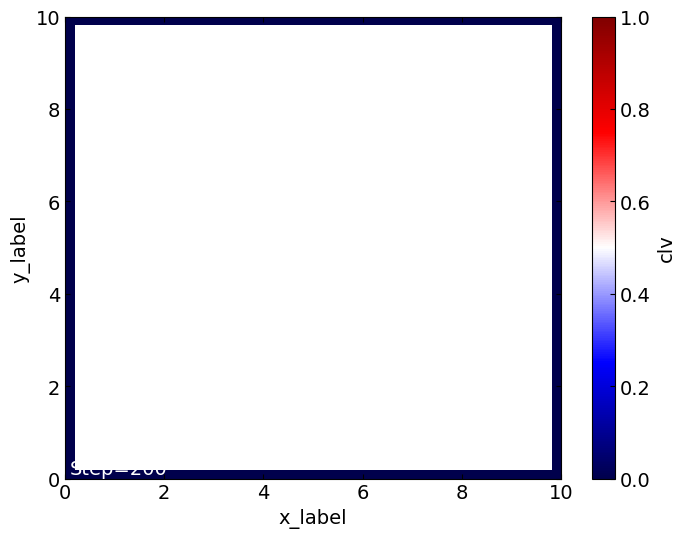

KeyboardInterrupt: 

In [6]:
    # 安定性の確認
    nu_x, nu_y = a * dt / dx ** 2, a * dt / dy ** 2
    print('nu_x, nu_y=', nu_x, nu_y)

    # 計算を実行
    sol_2d_diffusion(x, y, wus, clv, pull_sol)